# Housing Data Workflow Notebook

Modular workflow where you can run individual steps independently.
Run cells in order or skip any steps you don't need.

Each step shows dataframe views and statistics for inspection.

## Quick Start
- Run **Setup** cell first
- Then run any combination of Step 1-4 cells
- Skip cells you don't want to execute
- Each cell is self-contained and shows results

## 🔧 Setup

Run this cell first to import modules and define helper functions.

In [1]:
import sys
from pathlib import Path
from typing import Optional
import time

import pandas as pd

# Add current directory to path for local imports
sys.path.append(".")

# Import our workflow modules
from fetch_affordable_housing_data import update_local_data, verify_and_fetch_hpd_data
from query_ll44_funding import query_and_add_financing
from query_dob_filings import query_dob_bisweb_bin, query_dob_bisweb_bbl, query_dobnow_bin, query_dobnow_bbl, decompose_bbl, query_condo_lots_for_bbl, query_dob_by_address, pad_block, pad_lot
from query_co_filings import query_co_filings
from HPD_DOB_Join_On_BIN import create_separate_timelines
from create_timeline_chart import create_timeline_chart, create_financing_charts

print("✅ All imports successful")

# Helper functions
def _normalize_bin(bin_value) -> Optional[str]:
    """Normalize BIN to a clean string."""
    if pd.isna(bin_value):
        return None
    try:
        return str(int(float(bin_value)))
    except (TypeError, ValueError):
        value = str(bin_value).strip()
        return value or None

def _extract_bins_from_df(df: pd.DataFrame) -> list[str]:
    """Extract BINs from a DataFrame and return as a list for CO searches."""
    candidate_cols = []
    for col in df.columns:
        if col.lower() in ("bin", "bin_normalized"):
            candidate_cols.append(col)
    if not candidate_cols:
        raise SystemExit(f"Could not find a BIN column in DataFrame")

    bins = []
    for val in df[candidate_cols[0]].dropna():
        normalized = _normalize_bin(val)
        if normalized:
            bins.append(normalized)
    
    # Remove duplicates using set, then sort
    unique_bins = set()
    for b in bins:
        if b:
            unique_bins.add(b)
    return sorted(unique_bins)

def _query_co_filings_from_bins(bin_list: list[str], output_path: Path = None) -> pd.DataFrame:
    """Query CO filings using a list of BINs (no file needed)."""
    from query_co_filings import query_co_api, DOB_NOW_CO_URL, DOB_CO_URL
    
    # Convert BINs to integers for API query
    bin_ints = []
    for bin_str in bin_list:
        if str(bin_str).isdigit():
            bin_ints.append(int(bin_str))
    bins = sorted(list(set(bin_ints)))
    
    # Query DOB NOW Certificate of Occupancy API
    print("=" * 70)
    print("QUERYING DOB NOW CERTIFICATE OF OCCUPANCY")
    print("=" * 70)
    dob_now_co = query_co_api(DOB_NOW_CO_URL, bins, bin_column="bin")
    
    # Query DOB Certificate Of Occupancy API
    print("\n" + "=" * 70)
    print("QUERYING DOB CERTIFICATE OF OCCUPANCY")
    print("=" * 70)
    dob_co = query_co_api(DOB_CO_URL, bins, bin_column="bin_number")
    
    # Combine results
    print("\n" + "=" * 70)
    print("SUMMARY")
    print("=" * 70)
    
    if not dob_now_co.empty:
        print(f"\nDOB NOW CO Filings: {len(dob_now_co)} records")
        dob_now_co['source'] = 'DOB_NOW_CO'
        if 'bin' in dob_now_co.columns:
            dob_now_co['bin_normalized'] = dob_now_co['bin'].astype(str)
    
    if not dob_co.empty:
        print(f"\nDOB CO Filings: {len(dob_co)} records")
        dob_co['source'] = 'DOB_CO'
        if 'bin_number' in dob_co.columns:
            dob_co['bin_normalized'] = dob_co['bin_number'].astype(str)
    
    # Combine both dataframes
    if not dob_now_co.empty and not dob_co.empty:
        all_cols = list(set(dob_now_co.columns.tolist() + dob_co.columns.tolist()))
        if 'bin_normalized' not in all_cols:
            all_cols.append('bin_normalized')
        if 'source' not in all_cols:
            all_cols.append('source')
        dob_now_co_aligned = dob_now_co.reindex(columns=all_cols)
        dob_co_aligned = dob_co.reindex(columns=all_cols)
        combined = pd.concat([dob_now_co_aligned, dob_co_aligned], ignore_index=True)
    elif not dob_now_co.empty:
        combined = dob_now_co.copy()
    elif not dob_co.empty:
        combined = dob_co.copy()
    else:
        print("\nNo CO filings found in either API")
        return pd.DataFrame()
    
    print(f"\nTotal combined records: {len(combined)}")
    
    return combined

print("✅ Helper functions defined")

✅ All imports successful
✅ Helper functions defined


## 📥 Step 1: Fetch HPD Data

Load or refresh the HPD affordable housing dataset.

**Options:**
- Set `refresh_data = True` to fetch fresh data
- Set `refresh_data = False` to use existing data

In [2]:
# Step 1 Configuration
refresh_data = False  # Set to True to fetch fresh HPD data
hpd_output_path = "data/raw/Affordable_Housing_Production_by_Building.csv"  # Output path for HPD data
refresh_hpd_projects = False  # Set to True to fetch fresh HPD projects data

print("=" * 70)
print("STEP 1: FETCH HPD DATA")
print("=" * 70)

# Start quality tracking

# Handle HPD projects cache refresh if requested
if refresh_hpd_projects:
    print("Force refreshing HPD projects cache...")
    from fetch_affordable_housing_data import verify_and_fetch_hpd_projects_data
    hpd_projects_df, hpd_projects_path = verify_and_fetch_hpd_projects_data(use_existing=False)
    print(f"HPD projects cache refreshed: {len(hpd_projects_df)} records\n")

if refresh_data:
    print("Fetching fresh HPD data from NYC Open Data...")
    hpd_df, hpd_csv = update_local_data(hpd_output_path)
else:
    print("Verifying local HPD data against API...")
    hpd_df, hpd_csv = verify_and_fetch_hpd_data(output_path=hpd_output_path, use_projects_cache=not refresh_hpd_projects)

if not hpd_csv.exists():
    raise SystemExit(f"HPD dataset not found at {hpd_csv}")

# Get total units before filter
original_count = len(hpd_df)
original_units = hpd_df['Total Units'].sum()

# Filter to New Construction only
hpd_new_construction_df = hpd_df[hpd_df["Reporting Construction Type"] == "New Construction"].copy()

filtered_count = len(hpd_new_construction_df)
filtered_units = hpd_new_construction_df['Total Units'].sum()
filtered_out = original_count - filtered_count
filtered_units_out = original_units - filtered_units

print(f"🏗️ Filtered to New Construction only:")
print(f"  Original: {original_count:,} projects, {original_units:,} total units")
print(f"  Filtered: {filtered_count:,} projects ({filtered_count/original_count*100:.1f}%), {filtered_units:,} total units ({filtered_units/original_units*100:.1f}%)")
print(f"  Removed: {filtered_out:,} non-new construction projects ({filtered_out/original_count*100:.1f}%), {filtered_units_out:,} units filtered out ({filtered_units_out/original_units*100:.1f}%)")

print(f"✅ Step 1 complete: {len(hpd_new_construction_df):,} records loaded")
print(f"📁 Data location: {hpd_csv}")

# Display the dataframe
print("\n🔍 HPD Dataset Overview (New Construction only):")
print(f"Shape: {hpd_new_construction_df.shape}")
print("\nColumns:")
for col in hpd_new_construction_df.columns:
    print(f"  - {col}")

print("\n📊 Sample Data:")
display(hpd_new_construction_df.head())
print("\n📈 Basic Statistics:")
display(hpd_new_construction_df.describe(include="all"))

STEP 1: FETCH HPD DATA
Verifying local HPD data against API...
STEP 1: VERIFY AND FETCH HPD DATA
Found local HPD data file: data/raw/Affordable_Housing_Production_by_Building.csv
Local file has 8,604 records

Fetching 100 sample records from API for verification...
Fetching affordable housing data from NYC Open Data API...
Endpoint: https://data.cityofnewyork.us/resource/hg8x-zxpr.json
Fetching records 1-100...
  Retrieved 100 records (total: 100)

Completed! Retrieved 100 total records

Enriching building data with project-level information...
VERIFYING HPD PROJECTS CACHE
HPD projects cache file is stale (age: 0:03:28.045885) or use_existing=False
Fetching fresh data from API...
Created backup: data/raw/Affordable_Housing_Production_by_Project.csv.backup_20251201_213500
Fetching HPD Projects data from NYC Open Data API...
Endpoint: https://data.cityofnewyork.us/resource/hq68-rnsi.json
Fetching records 1-1000...
  Retrieved 1000 records (total: 1,000)
Fetching records 1001-2000...
  Re

,Project ID,Project Name,Project Start Date,Building ID,Number,Street,Borough,Postcode,BBL,BIN,...,6-BR+ Units,Unknown-BR Units,Counted Rental Units,Counted Homeownership Units,All Counted Units,Total Units,Program Group,Project Completion Date,Extended Affordability Status,Planned Tax Benefit
0,44218,MEC E. 125TH ST. PARCEL B WEST,2018-12-31T00:00:00.000,987329,2319,3 AVENUE,Manhattan,10035,1017907501,1054682,...,NaN,NaN,297.0,NaN,297.0,404,Multifamily Finance Program,2022-02-16T00:00:00.000,No,Article XI
1,44223,ROCHESTER SUYDAM PHASE 1,2021-06-30T00:00:00.000,927737,335,RALPH AVENUE,Brooklyn,11233,3015560003,3000000,...,NaN,NaN,NaN,13.0,13.0,13,Multifamily Finance Program,2024-09-24T00:00:00.000,No,Article XI
2,44223,ROCHESTER SUYDAM PHASE 1,2021-06-30T00:00:00.000,969695,35,ROCHESTER AVENUE,Brooklyn,11233,3017090009,3000000,...,NaN,NaN,NaN,8.0,8.0,8,Multifamily Finance Program,2024-09-24T00:00:00.000,No,Article XI
3,44223,ROCHESTER SUYDAM PHASE 1,2021-06-30T00:00:00.000,975702,18-22,SUYDAM PLACE,Brooklyn,11233,3017090028,3000000,...,NaN,NaN,NaN,15.0,15.0,15,Multifamily Finance Program,2024-09-24T00:00:00.000,No,Article XI
4,44223,ROCHESTER SUYDAM PHASE 1,2021-06-30T00:00:00.000,977564,329,RALPH AVENUE,Brooklyn,11233,3015560007,3000000,...,NaN,NaN,NaN,10.0,10.0,10,Multifamily Finance Program,2024-09-24T00:00:00.000,No,Article XI



📈 Basic Statistics:


,Project ID,Project Name,Project Start Date,Building ID,Number,Street,Borough,Postcode,BBL,BIN,...,6-BR+ Units,Unknown-BR Units,Counted Rental Units,Counted Homeownership Units,All Counted Units,Total Units,Program Group,Project Completion Date,Extended Affordability Status,Planned Tax Benefit
count,4216,4216,4216,3184,4216,4216,4216,3182,3115,3115,...,12.0,106.000000,3029.000000,1276.000000,4206.000000,4216.000000,4216,3297,4216,3113
unique,3749,2718,1850,3162,1965,1048,5,146,3007,2397,...,NaN,NaN,NaN,NaN,NaN,NaN,4,1437,2,8
top,53017,CONFIDENTIAL,2016-06-27T00:00:00.000,975696,----,----,Brooklyn,11239,2035150020,3000000,...,NaN,NaN,NaN,NaN,NaN,NaN,Multifamily Incentives Program,2019-05-28T00:00:00.000,No,421a
freq,83,1032,84,2,1032,1032,1873,165,9,331,...,NaN,NaN,NaN,NaN,NaN,NaN,2412,83,4214,2332
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.688679,37.684714,1.639498,27.636472,52.016129,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,6.993008,67.426568,4.116363,59.488316,107.460375,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.000000,3.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.000000,9.000000,1.000000,5.000000,10.000000,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.000000,38.000000,1.000000,20.000000,50.000000,NaN,NaN,NaN,NaN


In [3]:
# How many unique counts are there by project id as primary key per program group,
# and show total units in parentheticals (but NOT for the unique project counts).

# Compute total units per Program Group (all rows)
units_per_group = hpd_new_construction_df.groupby('Program Group')['Total Units'].sum()

print("Program Group counts (raw rows) (total units in parentheses):")
raw_row_counts = hpd_new_construction_df['Program Group'].value_counts()
for group, count in raw_row_counts.items():
    units = units_per_group.get(group, 0)
    print(f"{group}: {count} rows ({units} units)")
print()

# Group by Program Group, count unique Project IDs
unique_proj_counts = hpd_new_construction_df.groupby('Program Group')['Project ID'].nunique().sort_values(ascending=False)
unique_proj_ids = (
    hpd_new_construction_df
    .groupby('Program Group')
    .apply(lambda df: df['Project ID'].unique())
)

print("Program Group counts (unique Project ID as primary key):")
for group, count in unique_proj_counts.items():
    print(f"{group}: {count} projects")
print()

print("\nTax Abatement by Program Group (based on unique Project ID):")
if 'Planned Tax Benefit' in hpd_new_construction_df.columns:
    # For this, deduplicate by Project ID first
    unique_project_rows = hpd_new_construction_df.drop_duplicates(subset=['Project ID'])
    tax_abate_ct = (
        unique_project_rows
        .groupby('Program Group')['Planned Tax Benefit']
        .value_counts(dropna=False)
        .unstack(fill_value=0)
        .sort_index(axis=1)
    )
    # Also display total units per Program Group in this table, if desired
    units_per_group_project = unique_project_rows.groupby('Program Group')['Total Units'].sum()
    print("Total units (unique Project ID per Program Group):")
    display(units_per_group_project)
    display(tax_abate_ct)
else:
    print("Column 'Planned Tax Benefit' not found in dataset.")

# Make a version of this with unit count by program and tax benefit
if 'Planned Tax Benefit' in unique_project_rows.columns and 'Program Group' in unique_project_rows.columns:
    units_pivot = (
        unique_project_rows
        .groupby(['Program Group', 'Planned Tax Benefit'])['Total Units']
        .sum()
        .unstack(fill_value=0)
        .sort_index(axis=1)
    )
    print("Total units by Program Group and Planned Tax Benefit (unique Project ID only):")
    display(units_pivot)
else:
    print("Required columns not found for unit pivot table.")

# Calculate average units per year by Program Group and Planned Tax Benefit

if 'Project Start Date' in unique_project_rows.columns and 'Total Units' in unique_project_rows.columns:
    # Extract year from 'Project Start Date'
    unique_project_rows = unique_project_rows.copy()
    unique_project_rows['Project Year'] = pd.to_datetime(unique_project_rows['Project Start Date'], errors='coerce').dt.year

    avg_units_per_year = (
        unique_project_rows
        .groupby(['Program Group', 'Planned Tax Benefit', 'Project Year'])['Total Units']
        .sum()
        .reset_index()
    )

    # Now calculate the average units per year by program group and tax abatement
    avg_units_table = (
        avg_units_per_year
        .groupby(['Program Group', 'Planned Tax Benefit'])['Total Units']
        .mean()
        .unstack(fill_value=0)
        .sort_index(axis=1)
    )
    print("Average units per year by Program Group and Planned Tax Benefit (unique Project ID only):")
    display(avg_units_table)
else:
    print("Required columns not found for average units per year table.")



Program Group counts (raw rows) (total units in parentheses):
Multifamily Incentives Program: 2412 rows (152021 units)
Homeowner Assistance Program: 1027 rows (1027 units)
Multifamily Finance Program: 581 rows (64796 units)
Small Homes Program: 196 rows (1456 units)

Program Group counts (unique Project ID as primary key):
Multifamily Incentives Program: 2304 projects
Homeowner Assistance Program: 1027 projects
Multifamily Finance Program: 382 projects
Small Homes Program: 36 projects


Tax Abatement by Program Group (based on unique Project ID):
Total units (unique Project ID per Program Group):


/var/folders/cy/lk1n_dqn4gj0n_tsqkvpx_cw0000gn/T/ipykernel_1478/872236451.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: df['Project ID'].unique())


Program Group
Homeowner Assistance Program        1027
Multifamily Finance Program        57976
Multifamily Incentives Program    147060
Small Homes Program                  933
Name: Total Units, dtype: int64

Planned Tax Benefit,420a,420c,421a,467-M,485-X,Article IV,Article XI,UDAAP,NaN
Program Group,,,,,,,,,
Homeowner Assistance Program,0,0,0,0,0,0,0,0,1027
Multifamily Finance Program,3,255,24,0,0,0,75,2,23
Multifamily Incentives Program,1,30,2205,2,32,0,11,0,23
Small Homes Program,0,14,3,0,0,1,8,6,4


Total units by Program Group and Planned Tax Benefit (unique Project ID only):


Planned Tax Benefit,420a,420c,421a,467-M,485-X,Article IV,Article XI,UDAAP
Program Group,,,,,,,,
Multifamily Finance Program,233,36567,3806,0,0,0,13718,4
Multifamily Incentives Program,318,4271,136252,630,1068,0,449,0
Small Homes Program,0,485,80,0,0,6,229,16


Average units per year by Program Group and Planned Tax Benefit (unique Project ID only):


Planned Tax Benefit,420a,420c,421a,467-M,485-X,Article IV,Article XI,UDAAP
Program Group,,,,,,,,
Multifamily Finance Program,116.5,3047.250000,634.333333,0.0,0.0,0.0,1143.166667,2.0
Multifamily Incentives Program,318.0,388.272727,11354.333333,630.0,534.0,0.0,89.800000,0.0
Small Homes Program,0.0,53.888889,26.666667,0.0,0.0,6.0,38.166667,4.0


/var/folders/cy/lk1n_dqn4gj0n_tsqkvpx_cw0000gn/T/ipykernel_1478/828593675.py:48: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = cm.get_cmap('tab20', len(tax_benefits))
/var/folders/cy/lk1n_dqn4gj0n_tsqkvpx_cw0000gn/T/ipykernel_1478/828593675.py:125: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  handles_tax.append(plt.Rectangle((0,0),1,1, color=colors[i], edgecolor='black', label=f"{tax_benefits[i]}"))


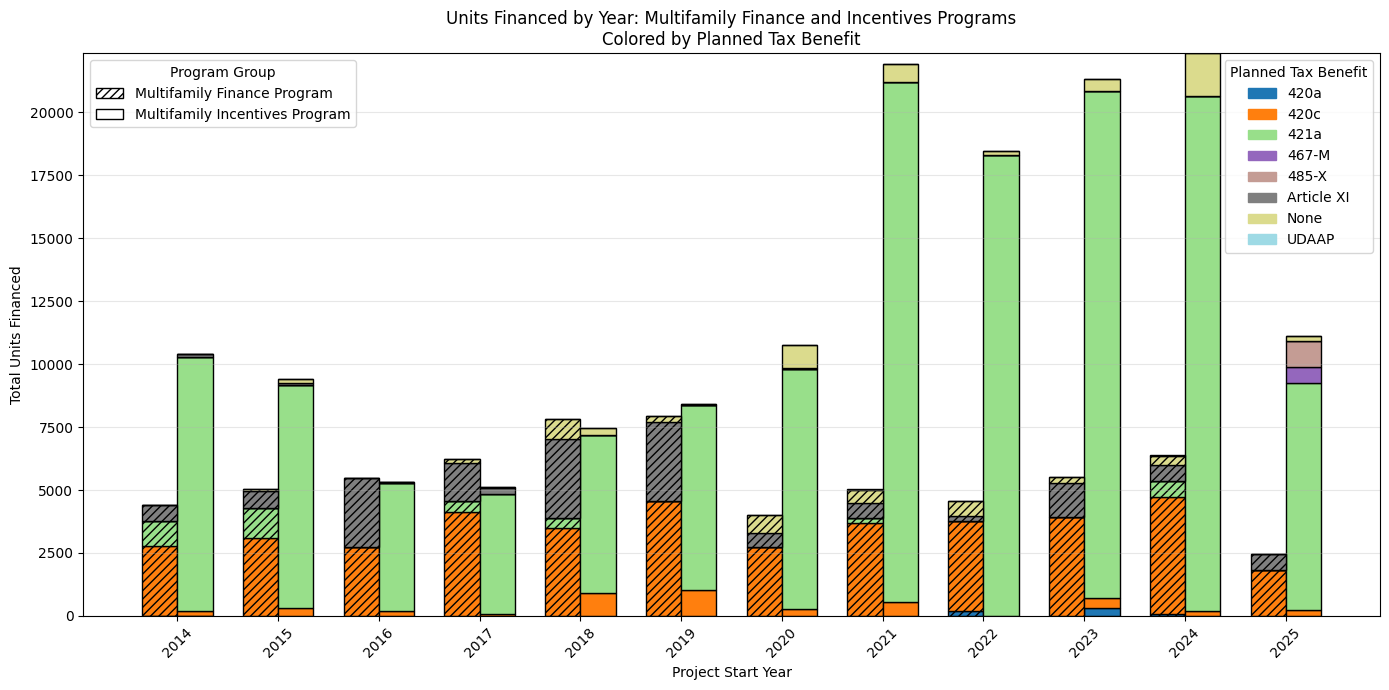

In [4]:
import matplotlib.pyplot as plt

# We'll use the full raw HPD data, because we want all programs, not just Multifamily Finance Program
if 'Project Start Date' in hpd_new_construction_df.columns and 'Total Units' in hpd_new_construction_df.columns:
    hpd_bar_df = hpd_new_construction_df.copy()
    hpd_bar_df['Project Year'] = pd.to_datetime(hpd_bar_df['Project Start Date'], errors='coerce').dt.year

    # Only focus on desired groups
    programs_of_interest = ['Multifamily Finance Program', 'Multifamily Incentives Program']
    mask = hpd_bar_df['Program Group'].isin(programs_of_interest)
    hpd_bar_df = hpd_bar_df[mask & hpd_bar_df['Project Year'].notna()]

    # Fill NAs in Planned Tax Benefit with "None"
    hpd_bar_df['Planned Tax Benefit'] = hpd_bar_df['Planned Tax Benefit'].fillna('None')

    # Prepare for grouped bar with stack
    # Pivot: rows = Project Year, columns = (Program Group, Planned Tax Benefit), values = sum of units
    pivot = (
        hpd_bar_df
        .groupby(['Project Year', 'Program Group', 'Planned Tax Benefit'])['Total Units']
        .sum()
        .reset_index()
    )

    # Ensure proper order of years and programs
    years = sorted(pivot['Project Year'].dropna().unique())
    tax_benefits = sorted(pivot['Planned Tax Benefit'].unique())
    # Keep consistent order for bars
    program_order = ['Multifamily Finance Program', 'Multifamily Incentives Program']

    # Prepare data structure: for each year, for each program, get breakdown by tax benefit
    bar_data = {}
    for year in years:
        bar_data[year] = {}
        for prog in program_order:
            mask = (pivot['Project Year'] == year) & (pivot['Program Group'] == prog)
            year_prog_data = pivot[mask].set_index('Planned Tax Benefit')['Total Units'].reindex(tax_benefits, fill_value=0)
            bar_data[year][prog] = year_prog_data.values

    # Number of bars per group (2 programs), group by year, stacked by tax benefit
    x = range(len(years))
    width = 0.35

    fig, ax = plt.subplots(figsize=(14, 7))

    # Colors for planned tax benefits
    import matplotlib.cm as cm
    color_map = cm.get_cmap('tab20', len(tax_benefits))
    colors = []
    for i in range(len(tax_benefits)):
        colors.append(color_map(i))

    bottoms_p1 = [0] * len(years)
    bottoms_p2 = [0] * len(years)

    # For each tax benefit, draw the stack pieces for both programs
    legend_handles = []
    for idx, tax in enumerate(tax_benefits):
        values_p1 = []
        for year in years:
            values_p1.append(bar_data[year][program_order[0]][idx])
        values_p2 = []
        for year in years:
            values_p2.append(bar_data[year][program_order[1]][idx])

        x_positions_p1 = []
        for i in x:
            x_positions_p1.append(i - width/2)
        x_positions_p2 = []
        for i in x:
            x_positions_p2.append(i + width/2)
        
        legend_labels = []
        for h in legend_handles:
            legend_labels.append(h.get_label())
        
        bar1 = ax.bar(
            x_positions_p1, values_p1, width,
            bottom=bottoms_p1, color=colors[idx],
            label=tax if (tax not in legend_labels) else None,
            edgecolor='black', hatch='////'
        )
        bar2 = ax.bar(
            x_positions_p2, values_p2, width,
            bottom=bottoms_p2, color=colors[idx],
            label=None,
            edgecolor='black'
        )

        legend_labels = []
        for h in legend_handles:
            legend_labels.append(h.get_label())
        if tax not in legend_labels:
            legend_handles.append(bar1)

        new_bottoms_p1 = []
        for b, v in zip(bottoms_p1, values_p1):
            new_bottoms_p1.append(b + v)
        bottoms_p1 = new_bottoms_p1
        
        new_bottoms_p2 = []
        for b, v in zip(bottoms_p2, values_p2):
            new_bottoms_p2.append(b + v)
        bottoms_p2 = new_bottoms_p2

    # Add year labels
    ax.set_xticks(x)
    year_labels = []
    for y in years:
        year_labels.append(str(int(y)))
    ax.set_xticklabels(year_labels, rotation=45)
    ax.set_xlabel("Project Start Year")
    ax.set_ylabel("Total Units Financed")
    ax.set_title("Units Financed by Year: Multifamily Finance and Incentives Programs\nColored by Planned Tax Benefit")

    # Custom legend for program groups
    import matplotlib.patches as mpatches
    progs = [
        mpatches.Patch(color='gray', label='Multifamily Finance Program', ec='black', hatch='////'),
        mpatches.Patch(color='gray', label='Multifamily Incentives Program', ec='black')
    ]
    # Only add one legend for planned tax benefit
    handles_tax = []
    for i in range(len(tax_benefits)):
        handles_tax.append(plt.Rectangle((0,0),1,1, color=colors[i], edgecolor='black', label=f"{tax_benefits[i]}"))
    legend1 = ax.legend(handles=handles_tax, title="Planned Tax Benefit", loc='upper right')
    ax.add_artist(legend1)
    # Add manual tick legend for program bars
    bar_locs = [x[0] - width/2, x[0] + width/2]
    ax.bar(bar_locs[0], 0, width, color='white', hatch='////', ec='black', label='Multifamily Finance Program')
    ax.bar(bar_locs[1], 0, width, color='white', ec='black', label='Multifamily Incentives Program')
    ax.legend(
        handles=[
            plt.Rectangle((0,0),1,1, facecolor='white', hatch='////', edgecolor='black', label='Multifamily Finance Program'),
            plt.Rectangle((0,0),1,1, facecolor='white', edgecolor='black', label='Multifamily Incentives Program')
        ], title="Program Group", loc='upper left'
    )

    ax.grid(True, which='major', axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("Required columns ('Project Start Date', 'Total Units') not found in HPD Data.")



In [5]:
# Count and sample: Planned Tax Benefit '421a' and Project Start Date in 2025
if "Planned Tax Benefit" in hpd_new_construction_df.columns and "Project Start Date" in hpd_new_construction_df.columns:
    # Filter for 421a and 2025 start year
    mask_421a_2025 = (
        (hpd_new_construction_df["Planned Tax Benefit"] == "421a") &
        (hpd_new_construction_df["Project Start Date"].astype(str).str.startswith("2025"))
    )
    hpd_421a_2025_df = hpd_new_construction_df[mask_421a_2025]

    # Count unique projects (by Project ID), and total units
    total_projects = hpd_421a_2025_df["Project ID"].nunique() if "Project ID" in hpd_421a_2025_df.columns else len(hpd_421a_2025_df)
    total_units = hpd_421a_2025_df["Total Units"].sum() if "Total Units" in hpd_421a_2025_df.columns else "N/A"

    print(f"Total projects with Planned Tax Benefit '421a' and 2025 Start Date: {total_projects:,}")
    print(f"Total units in these projects: {total_units:,}")

    # Show up to 5 sample rows
    pd.set_option('display.max_columns', None)
    print("\nSample 421a Planned Tax Benefit projects with Project Start Date in 2025:")
    display(hpd_421a_2025_df)
    pd.reset_option('display.max_columns')
else:
    print("One or both of the columns 'Planned Tax Benefit' or 'Project Start Date' not found in HPD DataFrame.")



Total projects with Planned Tax Benefit '421a' and 2025 Start Date: 136
Total units in these projects: 9,024

Sample 421a Planned Tax Benefit projects with Project Start Date in 2025:


,Project ID,Project Name,Project Start Date,Building ID,Number,Street,Borough,Postcode,BBL,BIN,Community Board,Council District,Census Tract,NTA - Neighborhood Tabulation Area,Latitude,Longitude,Latitude (Internal),Longitude (Internal),Building Completion Date,Reporting Construction Type,Extended Affordability Only,Prevailing Wage Status,Extremely Low Income Units,Very Low Income Units,Low Income Units,Moderate Income Units,Middle Income Units,Other Income Units,Studio Units,1-BR Units,2-BR Units,3-BR Units,4-BR Units,5-BR Units,6-BR+ Units,Unknown-BR Units,Counted Rental Units,Counted Homeownership Units,All Counted Units,Total Units,Program Group,Project Completion Date,Extended Affordability Status,Planned Tax Benefit
5478,70212,534 3RD AVENUE,2025-02-11T00:00:00.000,996025,534,3 AVENUE,Manhattan,10016,1008910044,1000000,MN-06,4,80,MN0603,40.746760,-73.977383,40.746941,-73.977628,NaN,New Construction,No,Non Prevailing Wage,NaN,NaN,7.0,NaN,NaN,NaN,3.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,7.0,NaN,7.0,160,Multifamily Incentives Program,NaN,No,421a
7215,74187,3051 ATLANTIC AVENUE,2025-06-12T00:00:00.000,1017563,3051,ATLANTIC AVENUE,Brooklyn,11208,3039570053,3336148,BK-05,37,1168,BK0501,40.678703,-73.882074,40.678942,-73.882297,NaN,New Construction,No,Non Prevailing Wage,NaN,5.0,5.0,3.0,NaN,NaN,2.0,NaN,11.0,NaN,NaN,NaN,NaN,NaN,13.0,NaN,13.0,49,Multifamily Incentives Program,NaN,No,421a
7669,75052,4-34 26TH AVENUE,2025-06-18T00:00:00.000,1017588,1934-04-01T00:00:00.000,26 AVENUE,Queens,11102,4009090035,4000000,QN-01,22,87,QN0102,40.776048,-73.932284,40.775449,-73.931577,NaN,New Construction,No,Non Prevailing Wage,NaN,NaN,26.0,NaN,6.0,NaN,8.0,8.0,16.0,NaN,NaN,NaN,NaN,NaN,32.0,NaN,32.0,138,Multifamily Incentives Program,NaN,No,421a
7670,75053,4-42 26TH AVENUE,2025-06-18T00:00:00.000,1017589,1942-04-01T00:00:00.000,26 AVENUE,Queens,11102,4009080012,4020640,QN-01,22,87,QN0102,40.776048,-73.932280,40.775171,-73.931122,NaN,New Construction,No,Non Prevailing Wage,NaN,NaN,19.0,NaN,3.0,NaN,4.0,7.0,11.0,NaN,NaN,NaN,NaN,NaN,22.0,NaN,22.0,108,Multifamily Incentives Program,NaN,No,421a
7671,75056,8-11 26TH AVENUE,2025-06-18T00:00:00.000,1017586,2025-08-11T00:00:00.000,26 AVENUE,Queens,11102,4009060001,4000000,QN-01,22,91,QN0102,40.775610,-73.930800,40.776033,-73.930280,NaN,New Construction,No,Non Prevailing Wage,NaN,NaN,34.0,NaN,8.0,NaN,23.0,19.0,NaN,NaN,NaN,NaN,NaN,NaN,42.0,NaN,42.0,186,Multifamily Incentives Program,NaN,No,421a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8579,77141,600 CROWN STREET,2025-05-02T00:00:00.000,872511,600,CROWN STREET,Brooklyn,11213,3014170008,3000000,BK-09,35,333,BK0901,40.665607,-73.938452,40.665272,-73.938113,NaN,New Construction,No,Non Prevailing Wage,NaN,NaN,NaN,NaN,30.0,NaN,NaN,12.0,18.0,NaN,NaN,NaN,NaN,NaN,30.0,NaN,30.0,100,Multifamily Incentives Program,NaN,No,421a
8580,77142,1054 41 STREET,2025-05-01T00:00:00.000,148901,1054,41 STREET,Brooklyn,11219,3055910027,3000000,BK-12,38,112,BK1201,40.642801,-73.992934,40.642526,-73.992919,NaN,New Construction,No,Non Prevailing Wage,NaN,NaN,NaN,NaN,9.0,NaN,NaN,4.0,5.0,NaN,NaN,NaN,NaN,NaN,9.0,NaN,9.0,28,Multifamily Incentives Program,NaN,No,421a
8581,77143,21-07 ASTORIA BLVD APARTMENTS,2025-04-25T00:00:00.000,979882,21-07,ASTORIA BOULEVARD,Queens,11102,4008840057,4000000,QN-01,22,69,QN0103,40.772138,-73.925630,40.772294,-73.925388,NaN,New Construction,No,Non Prevailing Wage,NaN,NaN,NaN,NaN,21.0,NaN,3.0,7.0,11.0,NaN,NaN,NaN,NaN,NaN,21.0,NaN,21.0,68,Multifamily Incentives Program,NaN,No,421a
8582,77144,1229 EASTERN PARKWAY,2025-04-23T00:00:00.000,1017561,1229,EASTERN PARKWAY,Brooklyn,11213,3013920073,3000000,BK-08,41,35701,BK0802,40.668609,-73.927454,40.669057,-73.927443,NaN,New Construction,No,Non Prevailing Wage,NaN,NaN,NaN,NaN,17.0,NaN,NaN,12.0,5.0,NaN,NaN,NaN,NaN,NaN,17.0,NaN,17.0,54,Multifamily Incentives Program,NaN,No,421a


In [6]:
# Filter to Multifamily Finance Program (already filtered to New Construction in Step 1)
original_count = len(hpd_new_construction_df)
print(f"Using HPD data from Step 1: {original_count:,} total buildings (New Construction)")

# Apply filters: Multifamily Finance Program (already filtered to New Construction in Step 1)
hpd_multifamily_finance_new_construction_df = hpd_new_construction_df[
    hpd_new_construction_df["Program Group"] == "Multifamily Finance Program"
].copy()
filtered_count = len(hpd_multifamily_finance_new_construction_df)

print(f"🏗️ Filtered to Multifamily Finance Program:")
print(f"  Original: {original_count:,} buildings (New Construction)")
print(f"  Filtered: {filtered_count:,} buildings ({filtered_count/original_count*100:.1f}%)")
print(f"📁 Created critical DataFrame in memory: {filtered_count:,} Multifamily Finance Program (New Construction) buildings")


Using HPD data from Step 1: 4,216 total buildings (New Construction)
🏗️ Filtered to Multifamily Finance Program:
  Original: 4,216 buildings (New Construction)
  Filtered: 581 buildings (13.8%)
📁 Created critical DataFrame in memory: 581 Multifamily Finance Program (New Construction) buildings


## 🏗️ Step 3: Query DOB Filings

Search for DOB New Building filings.


In [7]:
# Step 3A: BIN/BBL Prep and Filtering

# Use hpd_multifamily_finance_new_construction_df from Step 2.5 (in memory)
print(f"Using filtered dataset from Step 2.5: {len(hpd_multifamily_finance_new_construction_df):,} Multifamily Finance Program (New Construction) buildings")

# Extract BINs and BBLs from the filtered data
bins = []
bin_counts = hpd_multifamily_finance_new_construction_df['BIN'].value_counts()
unique_bins = bin_counts[bin_counts == 1].index.tolist()
# Extract BBLs properly using decompose_bbl function
from query_dob_filings import decompose_bbl

bbls = []
for idx, row in hpd_multifamily_finance_new_construction_df.iterrows():
    if pd.notna(row.get("BBL")):
        bbl_result = decompose_bbl(str(row["BBL"]))
        if bbl_result and len(bbl_result) >= 3:
            borough, block, lot = bbl_result
            bbls.append((borough, block, lot))


# Filter out bad/placeholder BINs (e.g., 1000000, 2000000, 3000000, 4000000, 5000000)
# These are placeholder values that don't exist in DOB
def is_bad_bin(bin_str):
    """Check if BIN is a placeholder/bad value."""
    if not bin_str or pd.isna(bin_str) or str(bin_str).lower() == 'nan':
        return True
    bin_str_clean = str(bin_str).strip()
    # Check for pattern: [1-5]000000 (borough placeholder BINs)
    if bin_str_clean in ['1000000', '2000000', '3000000', '4000000', '5000000']:
        return True
    return False

if 'BIN' in hpd_multifamily_finance_new_construction_df.columns:
    bins = []
for b in hpd_multifamily_finance_new_construction_df['BIN'].dropna():
        b_str = str(b)
        if b_str != 'nan':
            b_clean = b_str.replace('.0', '')
            if not is_bad_bin(b_clean) and b_clean in unique_bins:
                bins.append(b_clean)

if 'BBL' in hpd_multifamily_finance_new_construction_df.columns:
    bbl_col = hpd_multifamily_finance_new_construction_df['BBL'].astype(str).str.zfill(10)
    bbls = []
    for bbl_val in bbl_col:
        if len(bbl_val) == 10:
            bbl_tuple = (
                bbl_val[0],                     # borough code (as string)
                bbl_val[1:6],                   # block (padded 5 chars)
                bbl_val[6:]                     # lot   (padded 4 chars)
            )
            bbls.append(bbl_tuple)

print(f"\n📋 Prepared {len(bins)} BINs and {len(bbls)} BBLs for DOB queries")


Using filtered dataset from Step 2.5: 581 Multifamily Finance Program (New Construction) buildings

📋 Prepared 371 BINs and 581 BBLs for DOB queries


In [8]:
# 1. BISWEB BIN for all buildings

print("BISWEB BIN QUERY (ALL BUILDINGS)")
print("=" * 70)
print(f"▶️ Querying BISWEB BIN for {len(bins)} buildings...")
dob_bisweb_bin_df = query_dob_bisweb_bin(bins)
bisweb_bin_matches = set()
if not dob_bisweb_bin_df.empty and "bin__" in dob_bisweb_bin_df.columns:
    bisweb_bin_matches = set(dob_bisweb_bin_df["bin__"].dropna().astype(str).unique())
bisweb_bin_unmatched = []
for b in bins:
    if b not in bisweb_bin_matches:
        bisweb_bin_unmatched.append(b)
print(f"BISWEB BIN: {len(bisweb_bin_matches)} matches, {len(bisweb_bin_unmatched)} need BBL fallback")




# Preview BISWEB BIN results
if not dob_bisweb_bin_df.empty:
    print("\n📊 BISWEB BIN sample:")
    display(dob_bisweb_bin_df.head())
else:
    print("\n⚠️ No BISWEB BIN results")

BISWEB BIN QUERY (ALL BUILDINGS)
▶️ Querying BISWEB BIN for 371 buildings...

Querying DOB BISWEB API by BIN
Looking for job type: NB
Number of BINs to check: 371
  Querying batch 1 (BINs 1-300)...
    Found 1896 records
  Querying batch 2 (BINs 301-371)...
    Found 269 records

Total records found: 2165
BISWEB BIN: 334 matches, 37 need BBL fallback

📊 BISWEB BIN sample:


,job__,doc__,borough,house__,street_name,block,lot,bin__,job_type,job_status,...,pc_filed,existing_dwelling_units,special_action_date,fuel_burning,fuel_storage,owner_s_house_number,owner_shouse_street_name,city_,state,zip
0,321193793,02,BROOKLYN,10,SCHROEDERS WALK,04586,00202,3424763,NB,R,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,320597092,04,BROOKLYN,1355,ROGERS AVENUE,05229,00017,3328301,NB,X,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,121184173,02,MANHATTAN,260,WEST 153RD STREET,02038,00055,1089911,NB,X,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,121184173,03,MANHATTAN,260,WEST 153RD STREET,02038,00055,1089911,NB,X,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,220152607,02,BRONX,1761,WALTON AVENUE,02850,00063,2120490,NB,R,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# 2. DOB NOW BIN for all buildings
print("=" * 70)
print("DOB NOW BIN QUERY (ALL BUILDINGS)")
print("=" * 70)
print(f"▶️ Querying DOB NOW BIN for {len(bins)} buildings...")
dob_now_bin_df = query_dobnow_bin(bins)
dobnow_bin_matches = set()
if not dob_now_bin_df.empty:
    dobnow_bin_matches = set(dob_now_bin_df["bin"].dropna().astype(str).unique())
    print("📊 DOB NOW BIN sample:")
    display(dob_now_bin_df.head())
else:
    print("⚠️ No DOB NOW BIN results")

print(f"DOB NOW BIN: {len(dobnow_bin_matches)} unique BINs and {len(dob_now_bin_df)} total job records")


DOB NOW BIN QUERY (ALL BUILDINGS)
▶️ Querying DOB NOW BIN for 371 buildings...

Querying DOB NOW API by BIN
Looking for job type: New Building
Number of BINs to check: 371
  Querying batch 1 (BINs 1-300)...
    Found 11 records
  Querying batch 2 (BINs 301-371)...
    Found 101 records

Total records found: 112
📊 DOB NOW BIN sample:


,job_filing_number,filing_status,house_no,street_name,borough,block,lot,bin,commmunity_board,work_on_floor,...,temporary_place_of_assembly_work_type_,job_type,approved_date,signoff_date,applicants_middle_initial,filing_representative_middle_initial,built_1_information_value,built_2_information_value,built_2_a_information_value,built_2_b_information_value
0,X00969702-S1,Permit Entire,1415,OGDEN AVENUE,BRONX,2536,29,2003566,204,"Floor Number(s) 001 through 007, Roof",...,0,New Building,2024-05-24T16:20:04.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,X00969702-S3,LOC Issued,1415,OGDEN AVENUE,BRONX,2536,29,2003566,204,Open Space,...,0,New Building,2024-06-04T14:48:25.000,2025-10-10T00:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN
2,X00969702-P3,Approved,1415,OGDEN AVENUE,BRONX,2536,29,2003566,204,NaN,...,0,New Building,2025-06-12T10:27:25.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,X00969702-P1,Approved,1415,OGDEN AVENUE,BRONX,2536,29,2003566,204,Cellar-SO-4905-X00969702-I1,...,0,New Building,2025-05-02T11:40:27.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,X00969702-S5,Permit Entire,1415,OGDEN AVENUE,BRONX,2536,29,2003566,204,"Cellar, Floor Number(s) 001 through 007, Open ...",...,0,New Building,2024-06-17T14:28:05.000,NaN,S,NaN,NaN,NaN,NaN,NaN


DOB NOW BIN: 13 unique BINs and 112 total job records


In [10]:
# 3. DETERMINE UNMATCHED PROJECTS

# Combine matched BINs from both API queries
all_matched_bins = bisweb_bin_matches.union(dobnow_bin_matches)

# Find projects with BINs that failed both BISWEB and DOB NOW queries
# Create a DataFrame of projects whose BINs were not matched by either BISWEB or DOB NOW queries.
# This uses .isin(all_matched_bins) to check which projects' BINs are missing from the set of matched BINs,
# and selects only those projects to proceed to BBL fallback lookup.
unmatched_projects_df = hpd_multifamily_finance_new_construction_df[
    ~hpd_multifamily_finance_new_construction_df["BIN"]
        .astype(str)
        .str.replace(".0", "")
        .isin(all_matched_bins)
].copy()

print(f"BIN QUERY RESULTS SUMMARY")
print(f"=" * 50)
print(f"Total projects in dataset: {len(hpd_multifamily_finance_new_construction_df)}")
matched_projects = hpd_multifamily_finance_new_construction_df[hpd_multifamily_finance_new_construction_df["BIN"].astype(str).str.replace(".0", "").isin(all_matched_bins)]
print(f"Unique BINs found in BISWEB/DOB NOW APIs: {len(all_matched_bins)}")
print(f"Projects covered by those BINs: {len(matched_projects)} (some BINs cover multiple projects)")

# Analyze BIN sharing
bin_counts = hpd_multifamily_finance_new_construction_df["BIN"].value_counts()
bins_used_multiple_times = len(bin_counts[bin_counts > 1])
extra_projects_from_sharing = bin_counts[bin_counts > 1].sum() - bins_used_multiple_times
print(f"Projects needing fallback queries: {len(unmatched_projects_df)}")
print(f"BIN matching success rate: {len(matched_projects)/len(hpd_multifamily_finance_new_construction_df)*100:.1f}% of projects covered")

# Sanity check
total_accounted_for = len(matched_projects) + len(unmatched_projects_df)
print(f"Sanity check: {len(matched_projects)} + {len(unmatched_projects_df)} = {total_accounted_for} (should equal {len(hpd_multifamily_finance_new_construction_df)})")

if not unmatched_projects_df.empty:
    print(f"Unmatched projects will proceed to fallback queries (BBL → Condo → Address)")
else:
    print(f"All projects successfully matched via BIN queries! No fallbacks needed.")


BIN QUERY RESULTS SUMMARY
Total projects in dataset: 581
Unique BINs found in BISWEB/DOB NOW APIs: 343
Projects covered by those BINs: 343 (some BINs cover multiple projects)
Projects needing fallback queries: 238
BIN matching success rate: 59.0% of projects covered
Sanity check: 343 + 238 = 581 (should equal 581)
Unmatched projects will proceed to fallback queries (BBL → Condo → Address)


In [11]:
hpd_multifamily_finance_new_construction_df[
    (hpd_multifamily_finance_new_construction_df["BIN"].duplicated(keep=False)) & 
    (~hpd_multifamily_finance_new_construction_df["BIN"].astype(str).apply(is_bad_bin))
]

,Project ID,Project Name,Project Start Date,Building ID,Number,Street,Borough,Postcode,BBL,BIN,...,6-BR+ Units,Unknown-BR Units,Counted Rental Units,Counted Homeownership Units,All Counted Units,Total Units,Program Group,Project Completion Date,Extended Affordability Status,Planned Tax Benefit
71,44348,Crossroads Plaza- Rental Low,2014-01-28T00:00:00.000,950310,501,SOUTHERN BOULEVARD,Bronx,10455,2025827502,2128607,...,NaN,NaN,136.0,NaN,136.0,136,Multifamily Finance Program,2017-04-12T00:00:00.000,No,420c
77,44409,Crotona Terrace II,2015-06-25T00:00:00.000,927022,1825,BOSTON ROAD,Bronx,10460,2029847503,2124684,...,NaN,NaN,108.0,NaN,108.0,108,Multifamily Finance Program,2018-01-12T00:00:00.000,No,420c
271,50104,Crotona Terrace I aka 1825 Boston Road,2014-10-02T00:00:00.000,927022,1825,BOSTON ROAD,Bronx,10460,2029847503,2124684,...,NaN,NaN,80.0,NaN,80.0,80,Multifamily Finance Program,2016-10-28T00:00:00.000,No,421a
629,52610,Crossroads Plaza I,2014-12-19T00:00:00.000,950310,501,SOUTHERN BOULEVARD,Bronx,10455,2025827502,2128607,...,NaN,NaN,163.0,NaN,163.0,163,Multifamily Finance Program,2018-08-16T00:00:00.000,No,421a
633,52661,3160 Park Avenue (Mixed Income),2014-12-31T00:00:00.000,956798,855,COURTLANDT AVENUE,Bronx,10451,2024197501,2127131,...,NaN,NaN,57.0,NaN,57.0,152,Multifamily Finance Program,2016-12-15T00:00:00.000,No,Article XI
1092,53245,3160 Park Avenue (Low Income),2014-12-31T00:00:00.000,956798,855,COURTLANDT AVENUE,Bronx,10451,2024197501,2127131,...,NaN,NaN,95.0,NaN,95.0,152,Multifamily Finance Program,2016-12-15T00:00:00.000,No,Article XI
2405,61612,EBENEZER PLAZA PHASE 1A,2018-06-22T00:00:00.000,975696,94,NEW LOTS AVENUE,Brooklyn,11212,3038627501,3327047,...,NaN,NaN,197.0,NaN,197.0,197,Multifamily Finance Program,2022-07-21T00:00:00.000,No,420c
2937,64436,1755 WATSON AVENUE,2018-06-21T00:00:00.000,1012932,1120,ROSEDALE AVENUE,Bronx,10472,2037517501,2024208,...,NaN,NaN,135.0,NaN,135.0,135,Multifamily Finance Program,2024-02-29T00:00:00.000,No,420c
2938,64436,1755 WATSON AVENUE,2018-06-21T00:00:00.000,1012933,1111,COMMONWEALTH AVENUE,Bronx,10472,2037517501,2024208,...,NaN,NaN,123.0,NaN,123.0,123,Multifamily Finance Program,2024-02-29T00:00:00.000,No,420c
2939,64436,1755 WATSON AVENUE,2018-06-21T00:00:00.000,1012934,1755,WATSON AVENUE,Bronx,10472,2037517501,2024208,...,NaN,NaN,68.0,NaN,68.0,68,Multifamily Finance Program,2024-02-29T00:00:00.000,No,420c


In [12]:
# BISWEB BBL FALLBACK
if not unmatched_projects_df.empty:
    print("" + "=" * 70)
    print("BISWEB BBL FALLBACK")
    print("=" * 70)
    
    # Extract BBLs from unmatched projects
    bbl_tuples = []
    for _, row in unmatched_projects_df.iterrows():
        if pd.notna(row.get("BBL")):
            bbl_result = decompose_bbl(str(row["BBL"]))
            if bbl_result and len(bbl_result) >= 3:
                bbl_tuples.append(bbl_result)
    
    # Deduplicate BBLs
    bbl_tuples = list(set(bbl_tuples))
    print(f"Extracted {len(bbl_tuples)} unique BBLs from unmatched projects")
    
    # Query BISWEB BBL API
    print(f"▶️ Querying BISWEB BBL for {len(bbl_tuples)} BBLs...")
    dob_bisweb_bbl_df = query_dob_bisweb_bbl(bbl_tuples)
    
    # DOB NOW BBL fallback
    print("" + "=" * 70)
    print("DOB NOW BBL FALLBACK")
    print("=" * 70)
    dob_now_bbl_df = query_dobnow_bbl(bbl_tuples)
else:
    # No unmatched projects, initialize empty dataframes
    dob_bisweb_bbl_df = pd.DataFrame()
    dob_now_bbl_df = pd.DataFrame()


BISWEB BBL FALLBACK
Extracted 189 unique BBLs from unmatched projects
▶️ Querying BISWEB BBL for 189 BBLs...

Querying DOB BISWEB API by BBL
Looking for job type: NB
Number of BBLs to check: 189
  Querying batch 1 (50 BBLs)...
    Found 108 records
  Querying batch 2 (50 BBLs)...
    Found 147 records
  Querying batch 3 (50 BBLs)...
    Found 152 records
  Querying batch 4 (39 BBLs)...
    Found 119 records

Total records found: 526
DOB NOW BBL FALLBACK

Querying DOB NOW API by BBL
Looking for job type: New Building
Number of BBLs to check: 189
  Querying batch 1 (50 BBLs)...
    Found 230 records
  Querying batch 2 (50 BBLs)...
    Found 185 records
  Querying batch 3 (50 BBLs)...
    Found 41 records
  Querying batch 4 (39 BBLs)...
    Found 135 records

Total records found: 591


In [ ]:
# For Multifamily Finance Program (MFP) new construction projects, find those with no DOB match in any table.

# Use hpd_multifamily_finance_new_construction_df from Step 3A (already filtered to MFP new construction)
hpd_multifamily_finance_new_construction_for_matching_df = hpd_multifamily_finance_new_construction_df.copy()

# Defensive: set of unique Project IDs for matching
mfp_project_ids = set(hpd_multifamily_finance_new_construction_for_matching_df['Project ID'].unique())

# Combine all DOB dataframes and normalize BIN columns
all_dob_dfs = []

# Normalize BIN columns in each DOB dataframe
if not dob_bisweb_bin_df.empty:
    if 'bin__' in dob_bisweb_bin_df.columns:
        dob_bisweb_bin_df = dob_bisweb_bin_df.copy()
        dob_bisweb_bin_df['bin_normalized'] = dob_bisweb_bin_df['bin__'].astype(str).str.replace('.0', '')
    # Ensure BBL is displayed as a string, not float
    if 'bbl' in dob_bisweb_bin_df.columns:
        dob_bisweb_bin_df['bbl'] = dob_bisweb_bin_df['bbl'].apply(lambda x: str(int(float(x))).zfill(10) if pd.notna(x) else None)
    all_dob_dfs.append(dob_bisweb_bin_df)

if not dob_bisweb_bbl_df.empty:
    if 'bin__' in dob_bisweb_bbl_df.columns:
        dob_bisweb_bbl_df = dob_bisweb_bbl_df.copy()
        dob_bisweb_bbl_df['bin_normalized'] = dob_bisweb_bbl_df['bin__'].astype(str).str.replace('.0', '')
    elif 'bin' in dob_bisweb_bbl_df.columns:
        dob_bisweb_bbl_df = dob_bisweb_bbl_df.copy()
        dob_bisweb_bbl_df['bin_normalized'] = dob_bisweb_bbl_df['bin'].astype(str).str.replace('.0', '')
    # Ensure BBL is displayed as a string, not float
    if 'bbl' in dob_bisweb_bbl_df.columns:
        dob_bisweb_bbl_df['bbl'] = dob_bisweb_bbl_df['bbl'].apply(lambda x: str(int(float(x))).zfill(10) if pd.notna(x) else None)
    all_dob_dfs.append(dob_bisweb_bbl_df)

if not dob_now_bin_df.empty:
    if 'bin' in dob_now_bin_df.columns:
        dob_now_bin_df = dob_now_bin_df.copy()
        dob_now_bin_df['bin_normalized'] = dob_now_bin_df['bin'].astype(str).str.replace('.0', '')
    # Ensure BBL is displayed as a string, not float
    if 'bbl' in dob_now_bin_df.columns:
        dob_now_bin_df['bbl'] = dob_now_bin_df['bbl'].apply(lambda x: str(int(float(x))).zfill(10) if pd.notna(x) else None)
    all_dob_dfs.append(dob_now_bin_df)

if not dob_now_bbl_df.empty:
    if 'bin' in dob_now_bbl_df.columns:
        dob_now_bbl_df = dob_now_bbl_df.copy()
        dob_now_bbl_df['bin_normalized'] = dob_now_bbl_df['bin'].astype(str).str.replace('.0', '')
    # Ensure BBL is displayed as a string, not float
    if 'bbl' in dob_now_bbl_df.columns:
        dob_now_bbl_df['bbl'] = dob_now_bbl_df['bbl'].apply(lambda x: str(int(float(x))).zfill(10) if pd.notna(x) else None)
    all_dob_dfs.append(dob_now_bbl_df)

# Use combined_dob_df from Step 3A if available, otherwise combine here
if 'combined_dob_df' in globals() and not combined_dob_df.empty:
    combined_dob_with_normalized_bbl_df = combined_dob_df.copy()
    print(f'Total DOB records (from Step 3A): {len(combined_dob_with_normalized_bbl_df)}')
elif all_dob_dfs:
    combined_dob_with_normalized_bbl_df = pd.concat(all_dob_dfs, ignore_index=True)
    print(f'Total DOB records: {len(combined_dob_with_normalized_bbl_df)}')
else:
    combined_dob_with_normalized_bbl_df = pd.DataFrame()
    print('No DOB records found')

# Prepare HPD data for matching - normalize BIN and ensure BBL is string
hpd_multifamily_finance_new_construction_with_normalized_ids_df = hpd_multifamily_finance_new_construction_for_matching_df.copy()
hpd_multifamily_finance_new_construction_with_normalized_ids_df['bin_normalized'] = hpd_multifamily_finance_new_construction_with_normalized_ids_df['BIN'].astype(str).str.replace('.0', '')
hpd_multifamily_finance_new_construction_with_normalized_ids_df['bbl_normalized'] = hpd_multifamily_finance_new_construction_with_normalized_ids_df['BBL'].apply(lambda x: str(int(float(x))).zfill(10) if pd.notna(x) else None)

# Join on BIN first
if not combined_dob_with_normalized_bbl_df.empty and 'bin_normalized' in combined_dob_with_normalized_bbl_df.columns:
    hpd_matched_on_bin_df = pd.merge(
        hpd_multifamily_finance_new_construction_with_normalized_ids_df,
        combined_dob_with_normalized_bbl_df[['bin_normalized']].drop_duplicates(),
        on='bin_normalized',
        how='inner'
    )
    matched_project_ids_bin = set(hpd_matched_on_bin_df['Project ID'].unique())
    print(f'Projects matched on BIN: {len(matched_project_ids_bin)}')
else:
    matched_project_ids_bin = set()

# Join on BBL for those that didn't match on BIN
hpd_unmatched_on_bin_df = hpd_multifamily_finance_new_construction_with_normalized_ids_df[~hpd_multifamily_finance_new_construction_with_normalized_ids_df['Project ID'].isin(matched_project_ids_bin)]

# Initialize BBL matching result
matched_project_ids_bbl = set()

# Reconstruct BBL in DOB data for sources that don't have it (like BISWEB)
# Reconstruct BBL from borough, block, lot for records that don't have it
def reconstruct_bbl(row):
    if pd.isna(row.get('borough')) or pd.isna(row.get('block')) or pd.isna(row.get('lot')):
        return None
    borough_map = {'MANHATTAN': '1', 'BRONX': '2', 'BROOKLYN': '3', 'QUEENS': '4', 'STATEN ISLAND': '5'}
    borough_code = borough_map.get(str(row['borough']).upper(), None)
    if not borough_code:
        return None
    # Remove leading zeros from block/lot for BBL reconstruction
    block_str = str(int(float(str(row['block']).replace('.0', ''))))
    lot_str = str(int(float(str(row['lot']).replace('.0', ''))))
    # Reconstruct: borough(1) + block(5) + lot(4) = 10 digits
    bbl_str = borough_code + block_str.zfill(5) + lot_str.zfill(4)
    return bbl_str.zfill(10)

# Always reconstruct BBL for records that need it (BISWEB data doesn't have bbl column)
combined_dob_with_normalized_bbl_df['bbl_reconstructed'] = combined_dob_with_normalized_bbl_df.apply(reconstruct_bbl, axis=1)
# Normalize BBL in DOB data (use existing bbl or reconstructed)
# Use bbl column if available, otherwise use reconstructed BBL
if 'bbl' in combined_dob_with_normalized_bbl_df.columns:
    # Use existing bbl column, normalized to 10 digits
    combined_dob_with_normalized_bbl_df['bbl_normalized'] = combined_dob_with_normalized_bbl_df['bbl'].apply(lambda x: str(int(float(x))).zfill(10) if pd.notna(x) else None)
    # Fill missing values with reconstructed BBL
    if 'bbl_reconstructed' in combined_dob_with_normalized_bbl_df.columns:
        combined_dob_with_normalized_bbl_df['bbl_normalized'] = combined_dob_with_normalized_bbl_df['bbl_normalized'].fillna(combined_dob_with_normalized_bbl_df['bbl_reconstructed'])
elif 'bbl_reconstructed' in combined_dob_with_normalized_bbl_df.columns:
    # Use reconstructed BBL if no bbl column exists
    combined_dob_with_normalized_bbl_df['bbl_normalized'] = combined_dob_with_normalized_bbl_df['bbl_reconstructed']
else:
    combined_dob_with_normalized_bbl_df['bbl_normalized'] = None

# Now match on BBL
if 'bbl_normalized' in combined_dob_with_normalized_bbl_df.columns and combined_dob_with_normalized_bbl_df['bbl_normalized'].notna().any():
    hpd_matched_on_bbl_df = pd.merge(
        hpd_unmatched_on_bin_df,
        combined_dob_with_normalized_bbl_df[['bbl_normalized']].drop_duplicates(),
        on='bbl_normalized',
        how='inner'
    )
    matched_project_ids_bbl = set(hpd_matched_on_bbl_df['Project ID'].unique())
    print(f'Projects matched on BBL (fallback): {len(matched_project_ids_bbl)}')
else:
    matched_project_ids_bbl = set()
    print('No BBL data available for matching')

# Combine all matched project IDs
dob_matched_project_ids = matched_project_ids_bin | matched_project_ids_bbl

# Find projects without DOB matches
mfp_projects_without_dob = mfp_project_ids - dob_matched_project_ids

print(f'\nTotal Multifamily Finance Program new construction projects: {len(mfp_project_ids)}')
print(f'Projects with DOB matches: {len(dob_matched_project_ids)}')
print(f'Number of these with NO DOB row in any table: {len(mfp_projects_without_dob)}')

# Debug: show a sample of matched and unmatched projects
if len(matched_project_ids_bin) > 0:
    print(f'\nSample matched on BIN: {list(matched_project_ids_bin)[:3]}')
if len(matched_project_ids_bbl) > 0:
    print(f'Sample matched on BBL: {list(matched_project_ids_bbl)[:3]}')
if len(mfp_projects_without_dob) > 0:
    print(f'Sample unmatched: {list(mfp_projects_without_dob)[:3]}')

# DEBUG: Analyze a sample project to understand matching
if len(mfp_projects_without_dob) > 0:
    sample_project_id = list(mfp_projects_without_dob)[0]
    sample_project = hpd_multifamily_finance_new_construction_for_matching_df[hpd_multifamily_finance_new_construction_for_matching_df['Project ID'] == sample_project_id]
    print(f'\n=== DEBUG: Sample unmatched project ===')
    print(f'Project ID: {sample_project_id}')
    print(f'Number of buildings in project: {len(sample_project)}')
    sample_bins = sample_project['BIN'].dropna().astype(str).str.replace('.0', '').tolist()
    sample_bbls = sample_project['BBL'].dropna().apply(lambda x: str(int(float(x))).zfill(10) if pd.notna(x) else None).tolist()
    print(f'BINs in project: {sample_bins[:5]}')
    print(f'BBLs in project: {sample_bbls[:5]}')
    
    # Check if these BINs/BBLs exist in DOB data
    if not combined_dob_with_normalized_bbl_df.empty:
        if 'bin_normalized' in combined_dob_with_normalized_bbl_df.columns:
            dob_bins = set(combined_dob_with_normalized_bbl_df['bin_normalized'].dropna().astype(str).unique())
            matching_bins = []
            for b in sample_bins:
                if b in dob_bins:
                    matching_bins.append(b)
            print(f'BINs found in DOB data: {matching_bins[:5] if matching_bins else "None"}')
        if 'bbl' in combined_dob_with_normalized_bbl_df.columns:
            dob_bbls = set(combined_dob_with_normalized_bbl_df['bbl'].dropna().apply(lambda x: str(int(float(x))).zfill(10) if pd.notna(x) else None).unique())
            matching_bbls = []
            for b in sample_bbls:
                if b in dob_bbls:
                    matching_bbls.append(b)
            print(f'BBLs found in DOB data: {matching_bbls[:5] if matching_bbls else "None"}')
# Show the head of the table of unmatched projects (project-level)
if len(mfp_projects_without_dob) > 0:
    print("\nHead of unmatched Multifamily Finance Program new construction projects:")
    hpd_multifamily_finance_new_construction_unmatched_projects_df = hpd_multifamily_finance_new_construction_for_matching_df[hpd_multifamily_finance_new_construction_for_matching_df['Project ID'].isin(mfp_projects_without_dob)].copy()
    # Ensure BBL is displayed as a string, not float
    if 'BBL' in hpd_multifamily_finance_new_construction_unmatched_projects_df.columns:
        hpd_multifamily_finance_new_construction_unmatched_projects_df['BBL'] = hpd_multifamily_finance_new_construction_unmatched_projects_df['BBL'].apply(lambda x: str(int(float(x))).zfill(10) if pd.notna(x) else None)
    excluded_cols = [
        "Lot Area", "Available Units", "Privately Financed Units", "Extremely Low Income Units",
        "Very Low Income Units", "Low Income Units", "Moderate Income Units", "Middle Income Units",
        "Studio Units", "One Bedroom Units", "Two Bedroom Units", "Three Bedroom Units",
        "Four Bedroom Units", "Five Bedroom Units", "Six Bedroom Units", "Unknown Bedroom Units",
    ][:15]  # Limit extra-wide tables in notebook
    display_cols = []
    for c in hpd_multifamily_finance_new_construction_unmatched_projects_df.columns:
        if c not in excluded_cols:
            display_cols.append(c)
    display(hpd_multifamily_finance_new_construction_unmatched_projects_df[display_cols].head(10))
else:
    print("\nAll Multifamily Finance Program projects matched to DOB data!")


Total DOB records: 3394
Projects matched on BIN: 257
Projects matched on BBL (fallback): 93

Total Multifamily Finance Program new construction projects: 382
Projects with DOB matches: 350
Number of these with NO DOB row in any table: 32

Sample matched on BIN: ['64887', '63345', '57772']
Sample matched on BBL: ['64828', '73549', '67005']
Sample unmatched: ['66904', '58621', '65983']

=== DEBUG: Sample unmatched project ===
Project ID: 66904
Number of buildings in project: 1
BINs in project: ['3000000']
BBLs in project: ['3041547501']
BINs found in DOB data: None
BBLs found in DOB data: None

Head of unmatched Multifamily Finance Program new construction projects:


/var/folders/cy/lk1n_dqn4gj0n_tsqkvpx_cw0000gn/T/ipykernel_1478/1256705796.py:112: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined_dob_with_normalized_bbl_df['bbl_reconstructed'] = combined_dob_with_normalized_bbl_df.apply(reconstruct_bbl, axis=1)
/var/folders/cy/lk1n_dqn4gj0n_tsqkvpx_cw0000gn/T/ipykernel_1478/1256705796.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined_dob_with_normalized_bbl_df['bbl_normalized'] = combined_dob_with_normalized_bbl_df['bbl'].apply(lambda x: str(int(float(x))).zfill(10) if pd.

,Project ID,Project Name,Project Start Date,Building ID,Number,Street,Borough,Postcode,BBL,BIN,...,6-BR+ Units,Unknown-BR Units,Counted Rental Units,Counted Homeownership Units,All Counted Units,Total Units,Program Group,Project Completion Date,Extended Affordability Status,Planned Tax Benefit
71,44348,Crossroads Plaza- Rental Low,2014-01-28T00:00:00.000,950310,501,SOUTHERN BOULEVARD,Bronx,10455,2025827502,2128607,...,NaN,NaN,136.0,NaN,136.0,136,Multifamily Finance Program,2017-04-12T00:00:00.000,No,420c
77,44409,Crotona Terrace II,2015-06-25T00:00:00.000,927022,1825,BOSTON ROAD,Bronx,10460,2029847503,2124684,...,NaN,NaN,108.0,NaN,108.0,108,Multifamily Finance Program,2018-01-12T00:00:00.000,No,420c
271,50104,Crotona Terrace I aka 1825 Boston Road,2014-10-02T00:00:00.000,927022,1825,BOSTON ROAD,Bronx,10460,2029847503,2124684,...,NaN,NaN,80.0,NaN,80.0,80,Multifamily Finance Program,2016-10-28T00:00:00.000,No,421a
455,50497,655 Morris Avenue,2014-06-26T00:00:00.000,806842,635,MORRIS AVENUE,Bronx,10451,2024410001,2002441,...,NaN,NaN,176.0,NaN,176.0,176,Multifamily Finance Program,2016-12-01T00:00:00.000,No,420c
629,52610,Crossroads Plaza I,2014-12-19T00:00:00.000,950310,501,SOUTHERN BOULEVARD,Bronx,10455,2025827502,2128607,...,NaN,NaN,163.0,NaN,163.0,163,Multifamily Finance Program,2018-08-16T00:00:00.000,No,421a
1770,58621,TREE OF LIFE,2017-05-24T00:00:00.000,972781,89-48,164 STREET,Queens,11432,4097937502,4000000,...,NaN,NaN,174.0,NaN,174.0,174,Multifamily Finance Program,2024-05-23T00:00:00.000,No,Article XI
1788,58666,BRKG GND. AAPCI. 3 LIVONIA AVE. EDWIN'S PLACE,2018-06-28T00:00:00.000,968251,278,GRAFTON STREET,Brooklyn,11212,3035660006,3000000,...,NaN,NaN,126.0,NaN,126.0,126,Multifamily Finance Program,2020-09-22T00:00:00.000,No,420c
1961,58954,94-02 148th Street,2016-06-28T00:00:00.000,968125,94-02,148 STREET,Queens,11435,4099997501,4000000,...,NaN,NaN,380.0,NaN,380.0,380,Multifamily Finance Program,2018-09-24T00:00:00.000,No,Article XI
2360,61271,DOE. 555 NEREID AVE. MULLER,2019-03-28T00:00:00.000,99387,555,NEREID AVENUE,Bronx,10470,2050650001,2070559,...,NaN,NaN,90.0,NaN,90.0,90,Multifamily Finance Program,2021-07-09T00:00:00.000,No,420c
2361,61290,ICL. 50 NEVINS STREET,2019-03-26T00:00:00.000,342273,50,NEVINS STREET,Brooklyn,11217,3001727501,3000556,...,NaN,NaN,129.0,NaN,129.0,129,Multifamily Finance Program,2022-04-13T00:00:00.000,No,420c


In [ ]:
# Join HPD Multifamily Finance new construction rows to DOB data,
# first on BIN, then using BBL as a backup for rows without a BIN match.
# For each HPD row, add the earliest of DOB's 'paid', 'applied', or 'approved' date
# (whichever is earliest/present among these columns in the DOB data).

import numpy as np

def _get_earliest_date(row, date_cols):
    dates = [pd.to_datetime(row[col], errors='coerce') for col in date_cols if col in row and pd.notna(row[col])]
    return min(dates) if dates else pd.NaT

# Use the existing bbl_normalized column which includes both original bbl and reconstructed BBL
# If bbl_normalized doesn't exist, create it from the bbl column
dob_df = combined_dob_with_normalized_bbl_df.copy()

# Debug: Check if DOB NOW data is present
if 'source' in dob_df.columns:
    dob_now_count = len(dob_df[dob_df['source'].str.contains('DOB_NOW', case=False, na=False)])
    print(f"DOB NOW records in combined dataframe: {dob_now_count}")
    if dob_now_count > 0:
        dob_now_sample = dob_df[dob_df['source'].str.contains('DOB_NOW', case=False, na=False)].head(1)
        print(f"DOB NOW sample columns: {list(dob_now_sample.columns)}")
        print(f"DOB NOW date columns found: {[col for col in dob_now_sample.columns if 'date' in col.lower() or 'filing' in col.lower()]}")
else:
    print("No 'source' column found - cannot verify DOB NOW data presence")
if 'bbl_normalized' not in dob_df.columns:
    # Fallback: create bbl_normalized from bbl column if it doesn't exist
    dob_df['bbl_normalized'] = dob_df['bbl'].apply(lambda x: str(int(float(x))).zfill(10) if pd.notna(x) else None)
else:
    # Ensure bbl_normalized is properly formatted as string (10 digits, zero-padded)
    def format_bbl(x):
        if pd.isna(x) or x is None:
            return None
        try:
            # Try to convert to int then string, then pad
            return str(int(float(x))).zfill(10)
        except (ValueError, TypeError):
            # If it's already a string, check if it's valid
            x_str = str(x).strip()
            if x_str in ('None', 'nan', ''):
                return None
            # If it's already a 10-digit string, return as is
            if x_str.isdigit() and len(x_str) <= 10:
                return x_str.zfill(10)
            return None
    dob_df['bbl_normalized'] = dob_df['bbl_normalized'].apply(format_bbl)

# The date columns that might contain the milestone dates
# Collect BISWEB milestone columns (with various naming patterns)
bisweb_date_cols = []
for c in ['pre-filing', 'pre filing', 'pre- filing', 'paid', 'fully paid', 'assigned', 'approved', 'fully permitted']:
    matches = [col for col in dob_df.columns if col.lower().startswith(c)]
    bisweb_date_cols.extend(matches)

# DOB NOW milestone columns: check for both space and underscore versions
# DOB NOW API uses underscores: filing_date, first_permit_date, approved_date
dobnow_date_cols = []
for col in dob_df.columns:
    col_lower = col.strip().lower()
    # Check for space-separated versions (if API returns them that way)
    if col_lower in ['filing date', 'first approved date', 'first permit date', 'approved date']:
        dobnow_date_cols.append(col)
    # Check for underscore versions (actual DOB NOW API format)
    elif col_lower in ['filing_date', 'first_permit_date', 'first_approved_date', 'approved_date']:
        dobnow_date_cols.append(col)
    # Also check for partial matches (e.g., columns that start with these)
    elif any(col_lower.startswith(prefix) for prefix in ['filing_date', 'first_permit', 'first_approved', 'approved_date']):
        dobnow_date_cols.append(col)

# Combine, de-duplicate
date_cols = list(set(bisweb_date_cols + dobnow_date_cols))
print(f"Found {len(date_cols)} date columns: {date_cols}")

# Find earliest relevant DOB milestone date per BIN and BBL
dob_bin_dates = dob_df.copy()
dob_bin_dates['earliest_dob_date'] = dob_bin_dates.apply(lambda row: _get_earliest_date(row, date_cols), axis=1)

# Reduce DOB to earliest date per BIN and per BBL
# Filter out None/NaN BBLs before grouping to avoid grouping on None values
dob_bin_min = dob_bin_dates.groupby('bin_normalized', as_index=False)['earliest_dob_date'].min()
dob_bbl_min = dob_bin_dates[dob_bin_dates['bbl_normalized'].notna()].groupby('bbl_normalized', as_index=False)['earliest_dob_date'].min()

# Prepare HPD for matching
hpd_df = hpd_multifamily_finance_new_construction_df.copy()
hpd_df['BIN_str'] = hpd_df['BIN'].dropna().astype(str).str.replace('.0', '')
hpd_df['BBL_str'] = hpd_df['BBL'].apply(lambda x: str(int(float(x))).zfill(10) if pd.notna(x) else None)

# Merge on BIN first
hpd_with_date = pd.merge(
    hpd_df,
    dob_bin_min.rename(columns={'bin_normalized': 'BIN_str'}),
    how='left',
    on='BIN_str'
)
# For rows without a BIN match, try to fill using a BBL match
no_bin_match_mask = hpd_with_date['earliest_dob_date'].isna()
if no_bin_match_mask.any():
    to_fill = hpd_with_date.loc[no_bin_match_mask, ['BBL_str']]
    filled = pd.merge(
        to_fill,
        dob_bbl_min.rename(columns={'bbl_normalized': 'BBL_str'}),
        how='left',
        on='BBL_str'
    )
    # Fill only where not matched by BIN but matched by BBL
    hpd_with_date.loc[no_bin_match_mask, 'earliest_dob_date'] = filled['earliest_dob_date'].values

# Add result to our HPD dataframe
hpd_multifamily_finance_new_construction_with_dob_date_df = hpd_with_date

print("\nJoined HPD MFP new construction table with DOB earliest milestone dates (BIN→BBL fallback).")
print(hpd_multifamily_finance_new_construction_with_dob_date_df[['Project ID', 'BIN', 'BBL', 'earliest_dob_date']].head(10))
num_missing_earliest_dob_date = hpd_multifamily_finance_new_construction_with_dob_date_df['earliest_dob_date'].isna().sum()
print(f"\nCount of HPD MFP new construction rows without an earliest DOB milestone date: {num_missing_earliest_dob_date}")
# Filter HPD MFP new construction rows where 'earliest_dob_date' is missing (NaN)
no_dob_milestone_df = hpd_multifamily_finance_new_construction_with_dob_date_df[
    hpd_multifamily_finance_new_construction_with_dob_date_df['earliest_dob_date'].isna()
]

# Display the full table of rows without a DOB milestone date
no_dob_milestone_table = no_dob_milestone_df[['Project ID', 'Project Name', 'BIN', 'BBL', 'earliest_dob_date', 'BBL']]

print("\nFull table of projects without a DOB milestone date:")
display(no_dob_milestone_table)
print(f"Total without DOB milestone date: {len(no_dob_milestone_table)}")

# 1. How many have BBL (lot) that starts with "75"
def bbl_lot_starts_with_75(bbl):
    # BBLs are usually strings of length 10: borough (1), block (5), lot (4)
    # We'll check if positions 6-7 (block: 2nd and 3rd digits of the block) == '75'
    if pd.isna(bbl):
        return False
    bbl_str = str(int(float(bbl))).zfill(10)  # Ensure it's a 10-char string
    # Get lot (last 4 digits), see if startswith '75'
    lot_str = bbl_str[-4:]
    return lot_str.startswith('75')

lots_start_75_mask = no_dob_milestone_df['BBL'].apply(bbl_lot_starts_with_75)
num_lots_start_75 = lots_start_75_mask.sum()
print(f"\nHow many have BBL lot numbers starting with '75': {num_lots_start_75}")

# 2. How many have both BIN and BBL null, AND also have their Project ID duplicated in the FULL dataset
# (not just in the missing DOB milestone subset - one row can have DOB date, another can be missing)
null_bin_bbl_mask = no_dob_milestone_df['BIN'].isna() & no_dob_milestone_df['BBL'].isna()
null_bin_bbl_df = no_dob_milestone_df[null_bin_bbl_mask]

# Find Project IDs that are duplicated in the FULL dataset (not just missing DOB subset)
# This catches cases where a project has multiple buildings, some with DOB dates and some without
full_df = hpd_multifamily_finance_new_construction_with_dob_date_df
duplicated_project_ids_in_full = full_df['Project ID'][full_df['Project ID'].duplicated(keep=False)].unique()

# Among rows with null BIN/BBL and missing DOB date, find those whose Project ID appears multiple times in FULL dataset
null_bin_bbl_with_duplicated_projid = null_bin_bbl_df['Project ID'].isin(duplicated_project_ids_in_full)
count_null_bin_bbl_and_duplicated = null_bin_bbl_with_duplicated_projid.sum()
print(f"\nHow many have both BIN and BBL null and with a duplicated Project ID in FULL dataset: {count_null_bin_bbl_and_duplicated}")

# Also check if Project IDs are duplicated within the null BIN/BBL subset itself
# (catches cases where multiple rows for same project all have null BIN/BBL and missing DOB)
null_bin_bbl_duplicated_mask = null_bin_bbl_df['Project ID'].duplicated(keep=False)
count_null_bin_bbl_duplicated_in_subset = null_bin_bbl_duplicated_mask.sum()
print(f"How many have both BIN and BBL null and Project ID duplicated within null subset: {count_null_bin_bbl_duplicated_in_subset}")

# Optionally, print those rows for review
if count_null_bin_bbl_and_duplicated > 0:
    print("\nExamples of rows with both BIN and BBL null where Project ID appears multiple times in FULL dataset:")
    display(null_bin_bbl_df[null_bin_bbl_with_duplicated_projid][['Project ID', 'Project Name', 'BIN', 'BBL']])
    
    # Show all rows for these projects in the full dataset for context
    print("\nAll rows for these projects in FULL dataset (for context):")
    projects_to_show = null_bin_bbl_df[null_bin_bbl_with_duplicated_projid]['Project ID'].unique()
    all_rows_for_projects = full_df[full_df['Project ID'].isin(projects_to_show)]
    # Include Building ID as it's the primary key
    display_cols = ['Project ID', 'Building ID', 'Project Name', 'BIN', 'BBL', 'earliest_dob_date']
    # Only include columns that exist in the dataframe
    display_cols = [col for col in display_cols if col in all_rows_for_projects.columns]
    display(all_rows_for_projects[display_cols].sort_values('Project ID'))

if count_null_bin_bbl_duplicated_in_subset > 0:
    print("\nExamples of rows with both BIN and BBL null and duplicated Project IDs (within null subset):")
    display(null_bin_bbl_df[null_bin_bbl_duplicated_mask][['Project ID', 'Project Name', 'BIN', 'BBL']])


DOB NOW records in combined dataframe: 703
DOB NOW sample columns: ['job__', 'doc__', 'borough', 'house__', 'street_name', 'block', 'lot', 'bin__', 'job_type', 'job_status', 'job_status_descrp', 'latest_action_date', 'building_type', 'community___board', 'cluster', 'landmarked', 'loft_board', 'efiling_filed', 'other', 'other_description', 'applicant_s_first_name', 'applicant_s_last_name', 'applicant_professional_title', 'applicant_license__', 'professional_cert', 'pre__filing_date', 'paid', 'fully_paid', 'assigned', 'initial_cost', 'total_est__fee', 'fee_status', 'existing_zoning_sqft', 'proposed_zoning_sqft', 'enlargement_sq_footage', 'street_frontage', 'existingno_of_stories', 'proposed_no_of_stories', 'existing_height', 'proposed_height', 'owner_type', 'non_profit', 'owner_s_first_name', 'owner_s_last_name', 'owner_s_business_name', 'owner_sphone__', 'job_description', 'dobrundate', 'job_s1_no', 'total_construction_floor_area', 'withdrawal_flag', 'special_action_status', 'building_c

,Project ID,Project Name,BIN,BBL,earliest_dob_date,BBL
6,44225,Brook Avenue Apartments,2000000,2022927501,NaT,2022927501
18,44295,Van Sinderen Plaza,NaN,NaN,NaT,NaN
26,44348,Crossroads Plaza- Rental Low,2128607,2025827502,NaT,2025827502
32,44409,Crotona Terrace II,2124684,2029847503,NaT,2029847503
65,50104,Crotona Terrace I aka 1825 Boston Road,2124684,2029847503,NaT,2029847503
...,...,...,...,...,...,...
561,73540,SHF. 2950-2952 W 28TH ST. CONEY LANDING,NaN,NaN,NaT,NaN
563,73566,INNOVATIVE URBAN VILLAGE 1B,NaN,NaN,NaT,NaN
571,75335,HOUSINGWORKS. 2605-2611 PITKIN AVENUE,3094596,3042090041,NaT,3042090041
574,75731,HALLETTS POINT 20-30,NaN,NaN,NaT,NaN


Total without DOB milestone date: 74

How many have BBL lot numbers starting with '75': 23

How many have both BIN and BBL null and with a duplicated Project ID in FULL dataset: 10
How many have both BIN and BBL null and Project ID duplicated within null subset: 0

Examples of rows with both BIN and BBL null where Project ID appears multiple times in FULL dataset:


,Project ID,Project Name,BIN,BBL
18,44295,Van Sinderen Plaza,NaN,NaN
102,52467,FORD BEDFORD. 2848 BAINBRIDGE AVE.SERVIAM HEIGHTS,NaN,NaN
182,55080,SOUTH BUSHWICK NEIGHBORHOOD HOMES (SBNH),NaN,NaN
268,62211,THE GRAND,NaN,NaN
288,63757,SPOFFORD DETENTION CENTER PHASE 2,NaN,NaN
302,63777,APEX PLACE,NaN,NaN
363,64887,ROCKAWAY VILLAGE PHASE 5,NaN,NaN
381,65315,BED STUY CENTRAL AND NORTH PHASE I,NaN,NaN
518,69582,URBAN ECOSPACES,NaN,NaN
576,75925,RISEBORO. ALAFIA PH II,NaN,NaN



All rows for these projects in FULL dataset (for context):


,Project ID,Project Name,BIN,BBL,earliest_dob_date
17,44295,Van Sinderen Plaza,3427011,3038507501,2016-02-01
18,44295,Van Sinderen Plaza,NaN,NaN,NaT
101,52467,FORD BEDFORD. 2848 BAINBRIDGE AVE.SERVIAM HEIGHTS,2117126,2032910024,2008-06-19
102,52467,FORD BEDFORD. 2848 BAINBRIDGE AVE.SERVIAM HEIGHTS,NaN,NaN,NaT
179,55080,SOUTH BUSHWICK NEIGHBORHOOD HOMES (SBNH),3077905,3033890045,2015-11-09
180,55080,SOUTH BUSHWICK NEIGHBORHOOD HOMES (SBNH),3000000,3034010038,NaT
181,55080,SOUTH BUSHWICK NEIGHBORHOOD HOMES (SBNH),3000000,3034400035,2020-07-08
182,55080,SOUTH BUSHWICK NEIGHBORHOOD HOMES (SBNH),NaN,NaN,NaT
266,62211,THE GRAND,2128910,2028120001,2016-08-19
267,62211,THE GRAND,2128505,2028100017,2016-08-19


## 🏛️ Step 4: Query Certificate of Occupancy

Search for Certificate of Occupancy filings.

**Depends on:** Step 2
**Options:**
- Set `skip_co = True` to use existing CO data

In [ ]:
# Step 3B Configuration
skip_co = False  # Set to True to use existing CO data
co_output_path = None  # Custom CO output path

print("\n" + "=" * 70)
print("STEP 3B: QUERY CERTIFICATE OF OCCUPANCY")
print("=" * 70)

# Extract BINs from hpd_multifamily_finance_new_construction_df (in memory from Step 3A)
bins_list = _extract_bins_from_df(hpd_multifamily_finance_new_construction_df)
print(f"\n📋 Extracted {len(bins_list)} BINs from filtered dataset")

if skip_co:
    print("⏭️ Using existing CO data")
    # Look for existing CO files
    co_output = Path(co_output_path) if co_output_path else Path(
        f"data/processed/workflow_bins_co_filings.csv"
    )
    alt_co_path = Path(f"data/external/workflow_bins_co_filings.csv")
    if co_output.exists():
        print(f"📁 Using existing CO data at {co_output}")
        co_filings_df = pd.read_csv(co_output)
    elif alt_co_path.exists():
        print(f"📁 Using existing CO data from external folder: {alt_co_path}")
        co_filings_df = pd.read_csv(alt_co_path)
    else:
        print("⚠️ No existing CO data found")
        co_filings_df = None
else:
    print(f"🏛️ Querying CO APIs using {len(bins_list)} BINs (in memory)")
    co_filings_df = _query_co_filings_from_bins(bins_list, output_path=None)

# Display CO data if available
if co_filings_df is not None:
    print(f"📊 Certificate of Occupancy Data: {co_filings_df.shape[0]} records")
    print("Columns:")
    for col in co_filings_df.columns:
        print(f"  - {col}")
    
    print("\n📊 Sample CO Data:")
    display(co_filings_df.head())
    
    # Show some statistics
    if "issue_date" in co_filings_df.columns:
        print("\n📈 CO Issue Date Statistics:")
        display(co_filings_df["issue_date"].describe())
else:
    print("⚠️ No CO data available")

## 📊 Step 5: Generate Timelines and Charts

Create timeline visualizations from enriched data.

**Depends on:** Steps 2, 3A
**Options:**
- Set `skip_join = True` to skip timeline creation
- Set `skip_charts = True` to skip chart generation

In [ ]:
# Step 4 Configuration
skip_join = False   # Set to True to skip timeline creation
skip_charts = False # Set to True to skip chart generation

print("\n" + "=" * 70)
print("STEP 4: GENERATE TIMELINES AND CHARTS")
print("=" * 70)

if skip_join:
    print("⏭️ Skipping timeline join step.")
else:
    # Check if we have the required dataframes in memory
    if 'combined_dob_df' not in globals() or combined_dob_df.empty:
        print("⚠️ No DOB data available; skipping timeline creation.")
    else:
        print("🔗 Building timelines from in-memory dataframes...")
        
        # Create temporary files for timeline function (it expects file paths)
        import tempfile
        temp_building = Path(tempfile.mktemp(suffix="_buildings.csv"))
        temp_dob = Path(tempfile.mktemp(suffix="_dob.csv"))
        temp_co = Path(tempfile.mktemp(suffix="_co.csv")) if 'co_filings_df' in globals() and co_filings_df is not None and not co_filings_df.empty else None
        
        # Write dataframes to temporary files
        hpd_multifamily_finance_new_construction_df.to_csv(temp_building, index=False)
        combined_dob_df.to_csv(temp_dob, index=False)
        if temp_co:
            co_filings_df.to_csv(temp_co, index=False)
        
        try:
            create_separate_timelines(
                str(temp_building),
                str(temp_dob),
                str(temp_co) if temp_co else None,
            )
            
            # Load timeline results into dataframes
            # Function replaces .csv with _hpd_financed_timeline.csv
            hpd_timeline_path = Path(str(temp_building).replace('.csv', '_hpd_financed_timeline.csv'))
            private_timeline_path = Path(str(temp_building).replace('.csv', '_privately_financed_timeline.csv'))
            
            if hpd_timeline_path.exists():
                hpd_timeline_df = pd.read_csv(hpd_timeline_path)
                print(f"\n📊 HPD Financed Timeline Data ({hpd_timeline_df.shape[0]} records):")
                display(hpd_timeline_df.head())
                
                if "Event" in hpd_timeline_df.columns:
                    print("\n📈 Event Types in HPD Timeline:")
                    display(hpd_timeline_df["Event"].value_counts())
            
            if private_timeline_path.exists():
                private_timeline_df = pd.read_csv(private_timeline_path)
                print(f"\n📊 Privately Financed Timeline Data ({private_timeline_df.shape[0]} records):")
                display(private_timeline_df.head())
                
                if "Event" in private_timeline_df.columns:
                    print("\n📈 Event Types in Private Timeline:")
                    display(private_timeline_df["Event"].value_counts())
        finally:
            # Clean up temporary files
            if temp_building.exists():
                temp_building.unlink()
            if temp_dob.exists():
                temp_dob.unlink()
            if temp_co and temp_co.exists():
                temp_co.unlink()

if skip_charts:
    print("⏭️ Skipping chart generation.")
else:
    # Charts
    print("\n📈 Generating charts...")
    # Charts would need timeline files, which are created above
    # For now, skip chart generation if timelines weren't created
    if 'hpd_timeline_df' in locals() or 'private_timeline_df' in locals():
        print("⚠️ Chart generation from in-memory dataframes not yet implemented.")
        print("   Timeline dataframes are available in memory (hpd_timeline_df, private_timeline_df)")
    else:
        print("⚠️ No timeline data available for chart generation.")

print("\n✅ Step 4 complete")

## 📋 Final Summary

Generate data quality report and workflow summary.

**Optional:** Run this at the end to see final statistics.

In [ ]:
print("\n" + "=" * 70)
print("📊 FINAL SUMMARY")
print("=" * 70)

print("\n🎉 WORKFLOW COMPLETED!")

# Summary of what we accomplished
print("\n📋 WORKFLOW SUMMARY:")
try:
    print(f"• HPD Records Processed (New Construction): {len(hpd_new_construction_df):,}")
except NameError:
    print("• HPD Records: Step 1 not run")
try:
    print(f"• HPD Multifamily Finance Program (New Construction): {len(hpd_multifamily_finance_new_construction_df):,}")
except NameError:
    print("• HPD Multifamily Finance Program: Step 3A not run")
try:
    if 'combined_dob_df' in globals() and combined_dob_df is not None and not combined_dob_df.empty:
        print(f"• DOB Filings Found: {len(combined_dob_df):,}")
    else:
        print("• DOB Filings: No data")
except NameError:
    print("• DOB Filings: Step 3A not run")
try:
    if 'co_filings_df' in globals() and co_filings_df is not None and not co_filings_df.empty:
        print(f"• CO Filings Found: {len(co_filings_df):,}")
    else:
        print("• CO Filings: No data")
except NameError:
    print("• CO Filings: Step 3B not run")

print("\n✅ Notebook workflow complete!")
print("Each step showed dataframe views for inspection.")